In [1]:
import numpy as np
import tensorflow as tf
from core import *

In [2]:
IMG_DIM = 64
SNAPS = 16 ##Number of snaps over 4 seconds
STRIP_DEPTH = 8
STRIP_WIDTH = 42 * SNAPS
STRIP_HEIGHT = 51 * STRIP_DEPTH
SLICE = 1
CHANNELS = 1
CLASSES = 2
# CHANNELS = 8
conv1_filter = 8
conv2_filter = 8
conv3_filter = 16
conv4_filter = 16
conv5_filter = 32
conv6_filter = 32

In [3]:
experiment = 's16snap'
path = './datasets/' + experiment + '/'

_04847_img = np.load(path + '4847_' + experiment + '-image.npy')
_04799_img = np.load(path + '4799_' + experiment + '-image.npy')
_04820_img = np.load(path + '4820_' + experiment + '-image.npy')
_05675_img = np.load(path + '5675_' + experiment + '-image.npy')
_05680_img = np.load(path + '5680_' + experiment + '-image.npy')
_05710_img = np.load(path + '5710_' + experiment + '-image.npy')

_04847_lbl = np.load(path + '4847_' + experiment + '-label-onehot.npy')
_04799_lbl = np.load(path + '4799_' + experiment + '-label-onehot.npy')
_04820_lbl = np.load(path + '4820_' + experiment + '-label-onehot.npy')
_05675_lbl = np.load(path + '5675_' + experiment + '-label-onehot.npy')
_05680_lbl = np.load(path + '5680_' + experiment + '-label-onehot.npy')
_05710_lbl = np.load(path + '5710_' + experiment + '-label-onehot.npy')

#### Leave n examples out experiment (n=10)

In [4]:
n = 10
# train_img = np.vstack((_04847_img[n:,], _04799_img[n:,], _04820_img[n:,], _05675_img[n:,], _05680_img[n:,], _05710_img[n:,]))
# train_lbl = np.vstack((_04847_lbl[n:,], _04799_lbl[n:,], _04820_lbl[n:,], _05675_lbl[n:,], _05680_lbl[n:,], _05710_lbl[n:,]))
# val_img = np.vstack((_04847_img[:n,], _04799_img[:n,], _04820_img[:n,], _05675_img[:n,], _05680_img[:n,], _05710_img[:n,]))
# val_lbl = np.vstack((_04847_lbl[:n,], _04799_lbl[:n,], _04820_lbl[:n,], _05675_lbl[:n,], _05680_lbl[:n,], _05710_img[:n,]))

#### Leave on subject out experiments

In [5]:
# BAD 0.56 
# train_img = np.vstack((_04847_img[5:,], _04799_img[5:,], _04820_img[5:,], _05675_img[5:,], _05680_img[5:,]))
# train_lbl = np.vstack((_04847_lbl[5:,], _04799_lbl[5:,], _04820_lbl[5:,], _05675_lbl[5:,], _05680_lbl[5:,]))
# val_img = _05710_img
# val_lbl = _05710_lbl

In [6]:
# NOT BAD 0.6375
# train_img = np.vstack((_05710_img, _04799_img, _04820_img, _05675_img, _05680_img))
# train_lbl = np.vstack((_05710_lbl, _04799_lbl, _04820_lbl, _05675_lbl, _05680_lbl))
# val_img =  _04847_img
# val_lbl =  _04847_lbl 

In [7]:
# BAD 0.525
# train_img = np.vstack((_05710_img, _04847_img, _04820_img, _05675_img, _05680_img))
# train_lbl = np.vstack((_05710_lbl, _04847_lbl, _04820_lbl, _05675_lbl, _05680_lbl))
# val_img = _04799_img
# val_lbl = _04799_lbl

In [8]:
# GOOD 0.7875
train_img = np.vstack((_05710_img, _04847_img, _04799_img, _05675_img, _05680_img))
train_lbl = np.vstack((_05710_lbl, _04847_lbl, _04799_lbl, _05675_lbl, _05680_lbl))
val_img =  _04820_img
val_lbl =  _04820_lbl 

In [9]:
# GOOD 0.725
# train_img = np.vstack((_05710_img, _04847_img, _04799_img, _04820_img , _05680_img))
# train_lbl = np.vstack((_05710_lbl, _04847_lbl, _04799_lbl, _04820_lbl , _05680_lbl))
# val_img =  _05675_img
# val_lbl =  _05675_lbl

In [10]:
# NOT BAD 0.65
# train_img = np.vstack((_05710_img, _04847_img, _04799_img, _04820_img , _05675_img))
# train_lbl = np.vstack((_05710_lbl, _04847_lbl, _04799_lbl, _04820_lbl , _05675_lbl))
# val_img =  _05680_img
# val_lbl =  _05680_lbl

In [11]:
print 'train_img', train_img.shape
print 'train_lbl', train_lbl.shape
print 'val_img', val_img.shape
print 'val_lbl', val_lbl.shape

train_img (400, 408, 672)
train_lbl (400, 2)
val_img (80, 408, 672)
val_lbl (80, 2)


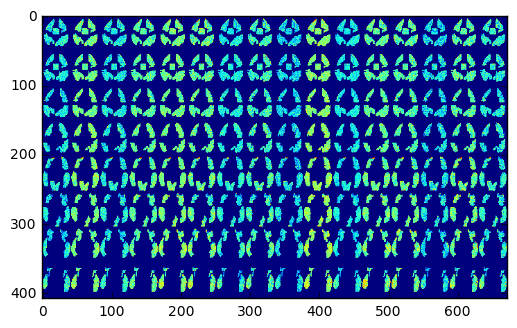

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.show(plt.imshow(train_img[1]))

In [13]:
x = tf.placeholder(tf.float32, shape=[None, STRIP_HEIGHT, STRIP_WIDTH], name='x')
x_image = tf.reshape(x, [-1, STRIP_HEIGHT, STRIP_WIDTH, CHANNELS], name='x_reshaped')
y_ = tf.placeholder(tf.float32, shape=[None, CLASSES], name='labels')
phase_train = tf.placeholder(tf.bool, name='phase_train')
keep_prob = tf.placeholder(tf.float32, name='keep_prob_fc1')

# 3 convolutional layers
conv1 = conv_layer(x_image, CHANNELS, conv1_filter, phase_train, 'conv1', 8, 8)
conv2 = conv_layer(conv1, conv1_filter, conv2_filter, phase_train, 'conv2', 5, 5)
conv3 = conv_layer(conv2, conv2_filter, conv3_filter, phase_train, 'conv3', 3, 3)

# maxpool
max_pool_1 = max_pool_layer(conv3, name='max_pool_1')

# 2 convolutional layers
conv4 = conv_layer(max_pool_1, conv3_filter, conv4_filter, phase_train, 'conv4', 3, 3)
conv5 = conv_layer(conv4, conv4_filter, conv5_filter, phase_train, 'conv5', 4, 4)

# maxpool
max_pool_2 = max_pool_layer(conv5, name='max_pool_2')

conv6 = conv_layer(max_pool_2, conv5_filter, conv6_filter, phase_train, 'conv6', 4, 4)
max_pool_3 = max_pool_layer(conv6, name='max_pool_3')

max_pool_count = 3
flattened_size = STRIP_HEIGHT * STRIP_WIDTH * conv6_filter/np.power(np.power(2,max_pool_count),2)
max_pool_3_flat = tf.reshape(max_pool_3, [-1, flattened_size]) # flatten 

fc1 = fc_layer(max_pool_3_flat, flattened_size, 1024, phase_train, 'fc1') # fc_layer fc1
fc1_drop = tf.nn.dropout(fc1, keep_prob) # dropout on fc1
fc2 = fc_layer(tf.nn.relu(fc1_drop), 1024, 512, phase_train, name='fc2') # fc_layer fc2
fc2_drop = tf.nn.dropout(fc2, keep_prob) # dropout on fc2
fc3 = fc_layer(tf.nn.relu(fc2_drop), 512, 256, phase_train, name='fc3') # fc_layer fc3
fc3_drop = tf.nn.dropout(fc3, keep_prob) # dropout on fc3
fc4 = fc_layer(tf.nn.relu(fc3_drop), 256, 128, phase_train, name='fc4') # fc_layer fc4
fc4_drop = tf.nn.dropout(fc4, keep_prob) # dropout on fc4
fc5 = fc_layer(tf.nn.relu(fc4_drop), 128, 64, phase_train, name='fc5') # fc_layer fc5
y_conv = fc_layer(fc5, 64, 2, phase_train, 'y_conv')    

In [ ]:
max_epochs = 200
starter_learning_rate = 1e-4
step = 400
decay = 0.95

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                step, decay, staircase=True)

step, train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr = 0, [], [], [], []

with tf.name_scope('xent'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    cross_entropy_count = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,
                                                                global_step = global_step)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_count = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar('cross_entropy', cross_entropy)
tf.summary.scalar('accuracy', accuracy)
# tf.summary.image('input', x_image, 3)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [ ]:
sess = tf.InteractiveSession()
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter('/tmp/brain/4')
writer.add_graph(sess.graph)

sess.run(tf.global_variables_initializer())

for i in range(max_epochs):
    for batch_xs, batch_ys in next_batch(train_img, train_lbl, 5):
        feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0, phase_train: True}
#         if step % 5 == 0:
#             s = sess.run(merged_summary, feed_dict=feed_dict)
#             writer.add_summary(s, step)

        train_step.run(feed_dict=feed_dict)
        step += 1

        if step % 100 == 0:
            
            train_loss, train_accuracy = loss_accuracy(cross_entropy_count, accuracy_count, x, y_, keep_prob, phase_train, train_img, train_lbl, 5)
            val_loss, val_accuracy = loss_accuracy(cross_entropy_count, accuracy_count, x, y_, keep_prob, phase_train, val_img, val_lbl, 5)
            
            train_acc_arr.append(train_accuracy), train_loss_arr.append(train_loss)
            val_acc_arr.append(val_accuracy), val_loss_arr.append(val_loss)

            print "lr %g, step %d, train accuracy %.4f, train loss %.5f, val accuracy %g, val loss %g" % (
                learning_rate.eval(), step, train_accuracy, train_loss, val_accuracy, val_loss)

lr 0.0001, step 100, train accuracy 0.5350, train loss 3.71660, val accuracy 0.5, val loss 2.9541
lr 0.0001, step 200, train accuracy 0.5475, train loss 6.43528, val accuracy 0.5, val loss 6.43386
lr 0.0001, step 300, train accuracy 0.5625, train loss 7.86502, val accuracy 0.5, val loss 7.95793
lr 9.5e-05, step 400, train accuracy 0.5575, train loss 6.78648, val accuracy 0.5875, val loss 2.50612
lr 9.5e-05, step 500, train accuracy 0.5650, train loss 7.30905, val accuracy 0.5, val loss 5.31751
lr 9.5e-05, step 600, train accuracy 0.6575, train loss 4.85898, val accuracy 0.575, val loss 4.146
lr 9.5e-05, step 700, train accuracy 0.6200, train loss 4.38911, val accuracy 0.4875, val loss 6.63114
lr 9.025e-05, step 800, train accuracy 0.5750, train loss 9.26533, val accuracy 0.5, val loss 14.0067
lr 9.025e-05, step 900, train accuracy 0.5875, train loss 7.60860, val accuracy 0.5, val loss 8.94023
lr 9.025e-05, step 1000, train accuracy 0.5775, train loss 5.55413, val accuracy 0.625, val lo

In [ ]:
test_loss, test_accuracy = loss_accuracy(cross_entropy_count, accuracy_count, x, y_, keep_prob, phase_train,
                                         val_img, val_lbl, 100)
print 'Val Accuracy: %g, Val Loss: %g' % (test_accuracy * 100, test_loss)

In [ ]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
get_available_devices()

In [ ]:
val_img.shape

In [ ]:
val_img[1,:,:,1].shape

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
for i in range(8):
    plt.show(plt.imshow(val_img[1,:,:,i]))

In [ ]:
plt.show(plt.imshow(np.concatenate(val_img[1], axis=1)))

In [ ]:
plt.show(plt.imshow(np.concatenate((val_img[1,:,:,0], val_img[1,:,:,1], val_img[1,:,:,2], val_img[1,:,:,3], val_img[1,:,:,4], val_img[1,:,:,5], val_img[1,:,:,6], val_img[1,:,:,7]), axis=1)))

In [ ]:
plt.show(plt.imshow(np.concatenate(val_img[1,:,:,[0,1,2,3,4,5,6,7]], axis=1)))

In [ ]:
val_img[1].T.T.T.shape